# Estimating COVID-19's $R_t$ in Real-Time

In [1]:
using StatsBase, Distributions, Plots, DataFrames, CSV, Dates, HTTP, Impute, DSP;

In [2]:
# some model parameters that will be used throughout this notebook
IFP = 7   # infectious period in days
GAMMA = 1/IFP  # recovery rate
SMOOTHING_PASSES = 5 # number of times to apply moving average filter to case data
println("IFP=",IFP," GAMMA=",GAMMA," SMOOTHING_PASSES=",SMOOTHING_PASSES)

IFP=7 GAMMA=0.14285714285714285 SMOOTHING_PASSES=5


Case reporting is very erratic based on testing backlogs, etc. We apply a smoothing filter to the time series. A real world process is not nearly as stochastic as the actual reporting.

In [3]:
function moving_average(seq; alpha=0.5)
    vs = seq
    if length(vs) > 1
        ret = 
            # vcat( vs[1], [ alpha * vs[i] + (1 - alpha)*vs[i-1] for i = 2:length(vs) ] )
            vcat((vs[1]+2*vs[1])/3,
                   [sum(@view vs[i:(i+2)])/3 for i in 1:(length(vs)-(2))],
                    (2*vs[length(vs)]+vs[length(vs)])/3)
    else
        ret = vs
    end
    return ret
    return Int64.(round.(ret))
end

moving_average (generic function with 1 method)

In [4]:
function smooth_sequence(seq)
    smooth_seq = copy(seq)
    for count in 1:SMOOTHING_PASSES
        smooth_seq = moving_average(smooth_seq) # approximates gaussian smoothing
    end
    return smooth_seq
end

smooth_sequence (generic function with 1 method)

## A Simulated outbreak

In [5]:
using Distributions, Plots
function sim_SIR_withRt(;R0 = 2, y = 1/7, pop = 1000000, init = 100, upper = 90)
  NC,Sv,Iv,Rv,Cv,Rtv = zeros(Int,upper),zeros(Int,upper),zeros(Int,upper),
    zeros(Int,upper),zeros(Int,upper),zeros(Float64,upper)
  b = R0 * y
  S = pop
  I = init
  C = I
  R = 0
  for i in 1:upper
      b = 1.001 * b
      new_cases = min(rand(Poisson(b*S*I/(S+I+R))),S)
      recoveries = min(rand(Poisson(y*I)),I)
      # must do the sampling before the updates
      I += new_cases
      S -= new_cases        
      I -= recoveries
      R += recoveries
       
      C += new_cases  
      Rt = R0*(S/(S+I+R)) 
       
      NC[i],Sv[i],Iv[i],Rv[i],Cv[i],Rtv[i] = new_cases,S,I,R,C,Rt
  end
  return NC,Sv,Iv,Rv,Cv,Rtv
end

sim_SIR_withRt (generic function with 1 method)

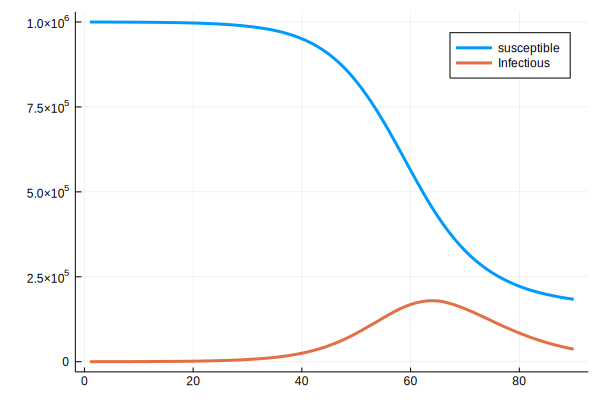

In [20]:
trial = sim_SIR_withRt();
fig_sim = plot([trial[2], trial[3]],labels=["susceptible" "Infectious"],lw=3)
savefig(fig_sim,"out/fig_RtSIM")
fig_sim

In [7]:
new_cases = trial[1]
cases = cumsum(new_cases)
infectives = [ cases[i]-cases[i-IFP] for i in IFP+1:length(cases) ]
smooth_inf = smooth_sequence(infectives)
rt_est = [ 1 + IFP * ((smooth_inf[i+1]-smooth_inf[i])/smooth_inf[i])
    for i in 1:length(smooth_inf)-1]
println("#rt_est = ",length(rt_est))
println("#Rtv = ",length(trial[6]))
fig_rt_est = plot([trial[6][IFP+2:end], rt_est ],labels=["simulated" "estimated"],lw=3)
savefig(fig_rt_est,output_url*"out/fig_rt_est")
fig_rt_est

#rt_est = 82
#Rtv = 90


UndefVarError: UndefVarError: output_url not defined

In [8]:
range = collect(1:1:40)
p_delay = [pdf.(Weibull(2, 7),t) for t in range]
p_delay = p_delay ./ sum(p_delay)
fig_pw = plot(range, p_delay, lw=3, label="Weibull(2,7)")
savefig(fig_pw,output_url*"out/fig_pw")
fig_pw

UndefVarError: UndefVarError: output_url not defined

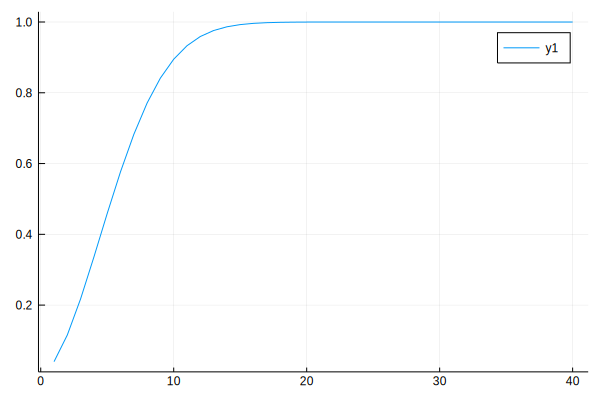

In [9]:
plot(cumsum(p_delay))

In [10]:
function estimate_onset(new_cases, p_delay)
    return reverse(conv(reverse(new_cases),p_delay))[length(p_delay):end]
end

estimate_onset (generic function with 1 method)

In [11]:
function adjust_onset(onset, p_delay)
    c_delay = cumsum(p_delay)
    extras = length(onset) - length(c_delay)
    cd = vcat(c_delay,ones(extras))
    adjusted = onset ./ reverse(cd)
    return adjusted[1:end]
end

adjust_onset (generic function with 1 method)

In [12]:
sum(p_delay)

0.9999999999999998

In [13]:
onset = estimate_onset(diff(cases),p_delay)
adj = adjust_onset(onset,p_delay)

89-element Array{Float64,1}:
   61.90944199111982
   69.87336439409046
   79.54031418534487
   90.57280133604945
  103.87319283855322
  119.37477280968142
  137.61003620236897
  158.32685587467222
  181.85645768725453
  209.05062169183338
  241.0780417605415 
  278.1852520170032 
  321.14814072728495
    ⋮               
 5062.398551314509  
 4629.696843456745  
 4253.864795174671  
 3928.978243042243  
 3654.1791505515375 
 3420.752116287507  
 3223.5722509973875 
 3055.6732156915655 
 2915.7975719634924 
 2794.6739568760186 
 2683.7992779651267 
 2571.0000000000296 

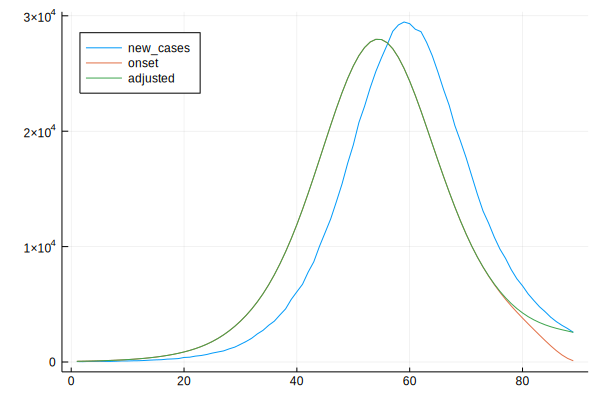

In [14]:
plot([diff(cases),onset,adj],labels=["new_cases" "onset" "adjusted"], legend=:topleft)

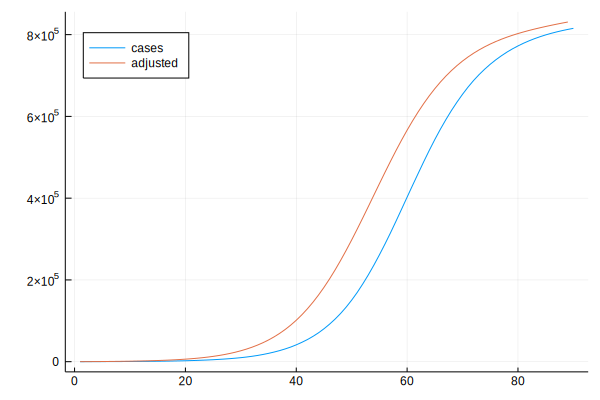

In [15]:
plot([cases,cumsum(adj)],labels=["cases" "adjusted"], legend=:topleft)

# Application to South African Data

In [28]:
output_url = "./"
url="https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
data = CSV.read(IOBuffer(HTTP.get(url).body),
            types=[String, String, Float64, Float64, Float64, Float64, Float64, 
                    Float64, Float64, Float64, Float64, Float64, Float64, String])
# parse date strings as Date
date_format = DateFormat("dd-mm-yyyy")
data[!,:date] = Date.(data[:,:date],date_format)
# select columns of interest and fill in missing rows with missing values
data = data[:,[:date, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :total]]
dr = data[1,:date]:Day(1):data[end,:date]
for d in dr
    if ! (d in data[:,:date])
        push!(data,vcat(d, [missing for i in 1:size(data)[2]-2], 0))
    end
end
sort!(data)
latest_date = maximum(data[:,:date])
# prepare to loop through each region and compute Rt values for each day
regions=names(data)[2:end]
# create an empty dataframe to hold Rt values
rtdf = DataFrame(date=Date[], province=String[], infs=Int64[], rts=Float64[])
fig_inf = plot(legendtitle="latest count",legend=:topleft,ylabel="infectives",
    title="tracking infectives in South Africa \n as of $latest_date")
fig_rts = plot(legendtitle="latest R",legend=:bottomleft,ylabel="R(t)", ylimits = [-1,3],
    title="tracking R(t) in South Africa \n as of $latest_date")
cases=[]
onset=[]
adj_cases=[]
for region in regions
    cases = Impute.interp(data[:,region])   # can impute on total cases (not on new-cases)
    onset = estimate_onset(diff(cases),p_delay)
    adj_cases = cumsum(adjust_onset(onset,p_delay))
    infectives = [ adj_cases[i]-adj_cases[i-IFP] for i in IFP+1:length(adj_cases) ]
    # lost IFP data points from infectives calc and 2 more from adjustment filter
    dates = data[IFP+2:end,:date] 
    max_inf = maximum(infectives)
    if(max_inf<100)
        println("skipping ... ",region," max(inf) = ",max_inf)
    else
        println("processing ... ",region," max(inf) = ",max_inf)
        # smooth_inf = infectives # smooth_sequence(infectives)
        dates = dates[infectives[:] .> 0]
        infectives = infectives[infectives[:] .> 0]
        smooth_inf = smooth_inf[infectives .> 0]
        rt_est = [ 1 + IFP * ((infectives[i+1]-infectives[i])/infectives[i]) 
            for i in 1:length(infectives)-1]
        
        for i in 1:length(dates)-1
            push!(rtdf,
            [dates[i] "$region" Int64(round(infectives[i])) round(rt_est[i],digits=2) ]
            )
        end
        rt_score = round(last(rt_est),digits=2)
        if (region == :total)
            lab = "ZA-$rt_score"
        else
            lab = "$region-$rt_score"
        end
        plot!(fig_rts, dates[2:end], rt_est,lw=6,m=:circle,label=lab)
        count = Int64(round(infectives[end],digits=0))
        if (region == :total)
            lab = "ZA-$count"
        else
            lab = "$region-$count"
        end
        plot!(fig_inf, dates, infectives,lw=6,m=:circle,label=lab)
    end
end
savefig(fig_rts,output_url*"out/fig_RtLiveZA")
savefig(fig_inf,output_url*"out/fig_InfLiveZA")
CSV.write(output_url*"out/provincial_rts.csv",rtdf)

processing ... EC max(inf) = 793.2412571410816
skipping ... FS max(inf) = 47.51397299855262
processing ... GP max(inf) = 438.98468620218136
processing ... KZN max(inf) = 246.50491748034074
skipping ... LP max(inf) = 61.76215469423238
skipping ... MP max(inf) = 21.953367821822518
skipping ... NC max(inf) = 11.585628431531163
skipping ... NW max(inf) = 29.976898692624914
processing ... WC max(inf) = 4995.345477892209
processing ... total max(inf) = 6610.289088972111


"./out/provincial_rts.csv"

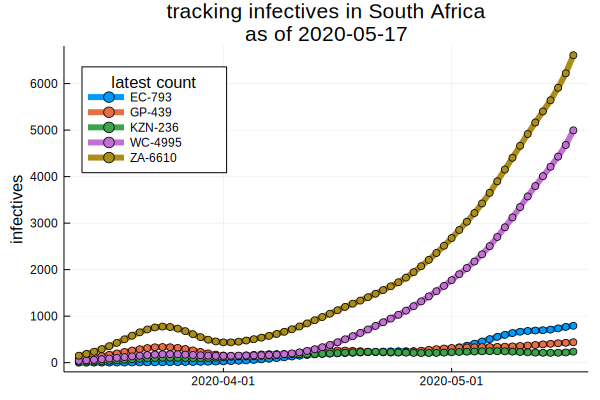

In [26]:
fig_inf

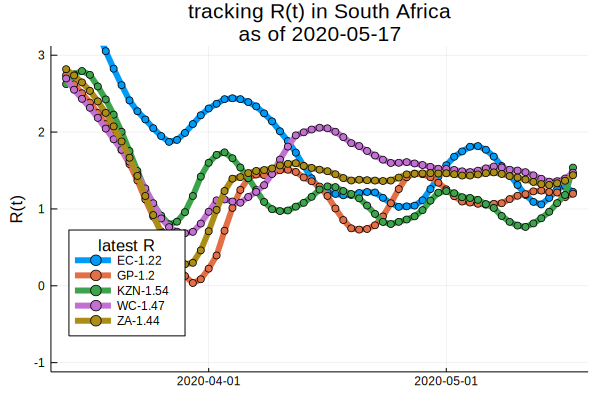

In [27]:
fig_rts

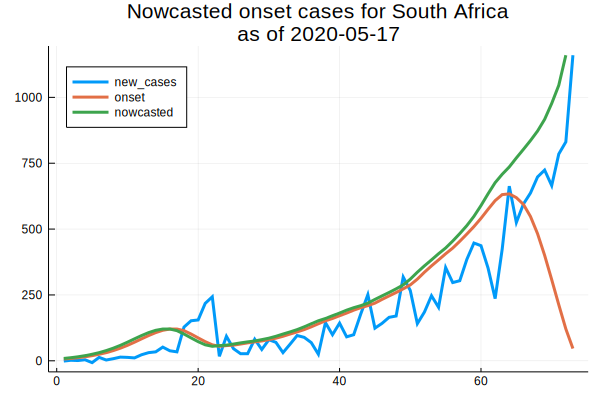

In [33]:
fig_adj_ZA = plot([diff(cases),onset,diff(adj_cases)],lw=3,
    labels=["new_cases" "onset" "nowcasted"], legend=:topleft,
    title="Nowcasted onset cases for South Africa \n as of $latest_date")
savefig(fig_adj_ZA,output_url*"out/fig_onset_nowZA")
fig_adj_ZA

In [2]:
exp(-0.4)

0.6703200460356393

In [3]:
(7*19630*1.2)/(8858*exp(0.4))

12.478032629364263

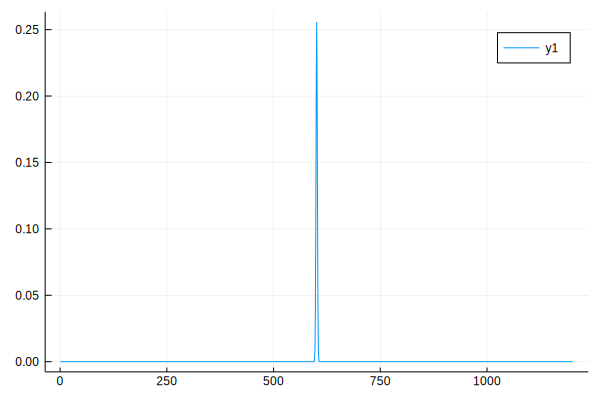

In [12]:
using DSP, Plots
RTL=1201
SIGMA=0.0013
GW = DSP.Windows.gaussian(RTL,SIGMA)
GW = GW ./ sum(GW)
plot(GW)

In [11]:
println(GW)

[1.5e-323, 1.8e-322, 2.1e-321, 2.445e-320, 2.8364e-319, 3.27701e-318, 3.7705825e-317, 4.32070363e-316, 4.93078335e-315, 5.603931094e-314, 6.3428592741e-313, 7.149781819616e-312, 8.026309938357e-311, 8.97334750622255e-310, 9.990988777520743e-309, 1.1078421360795547e-307, 1.2233837599319388e-306, 1.3454357603428483e-305, 1.4735967190169684e-304, 1.607347388292294e-303, 1.7460483901847147e-302, 1.8889402731516268e-301, 2.0351461386605557e-300, 2.1836769916398424e-299, 2.3334399006173997e-298, 2.483248976636134e-297, 2.631839097041107e-296, 2.7778822137393572e-295, 2.9200059985232603e-294, 3.0568144938133263e-293, 3.1869103590756066e-292, 3.308918234518448e-291, 3.421508687520204e-290, 3.5234221663644382e-289, 3.613492362458444e-288, 3.6906683778152975e-287, 3.7540351101417806e-286, 3.802831303336346e-285, 3.8364647658925113e-284, 3.8545243319253556e-283, 3.856788227104058e-282, 3.843228601485678e-281, 3.8140120997498226e-280, 3.769496452480386e-279, 3.710223185998241e-278, 3.6369066584462

, 2.0209435595562936e-11, 3.054246608427085e-11, 4.596946395263804e-11, 6.890491517663269e-11, 1.028599689981612e-10, 1.52917785281278e-10, 2.2640448904207487e-10, 3.3383163649168966e-10, 4.902136195006932e-10, 7.169001616084805e-10, 1.0441127697170144e-9, 1.5144382152360368e-9, 2.1876162288168996e-9, 3.1470680705022817e-9, 4.508754207982526e-9, 6.4331311944606155e-9, 9.141209865819917e-9, 1.293601095800094e-8, 1.8231084064141917e-8, 2.5588217653755815e-8, 3.576704016986237e-8, 4.978991587276928e-8, 6.902639720403721e-8, 9.530253299578833e-8, 1.310415751799865e-7, 1.7944410255686103e-7, 2.447173146830132e-7, 3.323652656027661e-7, 4.4955412489328193e-7, 6.055691838582076e-7, 8.123832684847236e-7, 1.085359464078681e-6, 1.4441145661699465e-6, 1.913573390872751e-6, 2.5252479181451573e-6, 3.3187790806217296e-6, 4.343782685180618e-6, 5.662044254311726e-6, 7.35011023952827e-6, 9.502324776361124e-6, 1.2234361553172845e-5, 1.5687299036099326e-5, 2.0032283766378546e-5, 2.5475820225335676e-5, 3.2

 8.26796185158791e-180, 1.3200341234017056e-180, 2.09887838800336e-181, 3.323569899396404e-182, 5.241285079589578e-183, 8.231636248523252e-184, 1.287508140090298e-184, 2.0055302629329827e-185, 3.1111709839842144e-186, 4.806555523472617e-187, 7.395362571058756e-188, 1.1331839171261518e-188, 1.7292459093930604e-189, 2.6280192111056106e-190, 3.977550827219449e-191, 5.995402767849259e-192, 8.999873681157177e-193, 1.345457201044082e-193, 2.0031745073840238e-194, 2.970182299841979e-195, 4.385941658175124e-196, 6.44997481456483e-197, 9.44644958255372e-198, 1.3778267967411886e-198, 2.0014100051793343e-199, 2.895295730184829e-200, 4.171240369244364e-201, 5.984845283082396e-202, 8.55177098995937e-203, 1.2169552834179019e-203, 1.7246802992261334e-204, 2.434209809420424e-205, 3.421549580998928e-206, 4.789642412087963e-207, 6.677267388067159e-208, 9.270643235128466e-209, 1.2818475942806057e-209, 1.765136683788274e-210, 2.420670694634438e-211, 3.3060430770550254e-212, 4.4967291256319306e-213, 6.0911

In [24]:
using StatsBase, Distributions
pdf(Poisson(5.1),0)

0.006096746565515638